In [1]:
import os
import time

import tensorrt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import (Activation, BatchNormalization, Conv2D, 
                          Conv2DTranspose, Dense, Dropout, Flatten, Input, 
                          LeakyReLU, Reshape, UpSampling2D)
from keras.utils import to_categorical
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm 

2023-11-15 13:52:02.087965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-11-15 13:52:03.972222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-15 13:52:03.987854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-15 13:52:03.989736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Deep Convolutional GAN

Author: George Stathopoulos

Last modified: April 4, 2022

Description: A script to train a GAN on MNIST. Generates image samples from the generator and saves to a local directory, does not save the models.

In [3]:
# Some constants
MNIST_SIZE = 28
LATENT_DIM = 100

## Return MNIST dataset, shaped appropriately depending on whether we are
## want to train a dense or convolutional neural net
def get_data():
    # Import the MNIST dataset using Keras
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Normalize input images to have all values in [0, 1]
    # Reshape image dataset to have shape (N, H, W, C) instead of (N, H, W)
    X_train = X_train.reshape((*(X_train.shape), 1)) / 255
    X_test = X_test.reshape((*(X_test.shape), 1)) / 255

    # Convert labels to one-hot vectors (probability distributions w/
    # probability 1 assigned to the correct label)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return (X_train, y_train), (X_test, y_test)

def make_generator(num_filters=64, num_hidden_conv_layers=2, init_dim=7):
    gen = Sequential()
    # Model input is a feature vector of size 100
    gen.add(Dense(init_dim**2 * num_filters, input_dim=LATENT_DIM))
    gen.add(Activation('relu'))
    gen.add(Reshape((init_dim, init_dim, num_filters)))

    for _ in range(num_hidden_conv_layers):
        # Input: d x d x k
        # Output 2d x 2d x k/2
        if (init_dim < MNIST_SIZE):
            gen.add(UpSampling2D())
            init_dim *= 2
        num_filters //= 2
        gen.add(Conv2DTranspose(num_filters, 5, padding='same'))
        gen.add(BatchNormalization(momentum=0.4))
        gen.add(Activation('relu'))

    gen.add(Conv2DTranspose(1, 5, padding='same'))
    gen.add(Activation('sigmoid'))
    # Output should be 28 x 28 x 1
    # gen.summary()
    return gen

def make_discriminator(num_filters=32, num_hidden_layers=3, dropout=0.3):
    d = Sequential()

    d.add(Conv2D(num_filters*1, 5, strides=2,
                 input_shape=(MNIST_SIZE, MNIST_SIZE, 1), padding='same'))
    d.add(LeakyReLU()) # leakyrelu so generator has derivative
    d.add(Dropout(dropout))

    for i in range(1, num_hidden_layers):
        # Powers of 2 are generally better suited for GPU
        d.add(Conv2D(num_filters * 2**i, 5, strides=2, padding='same'))
        d.add(LeakyReLU())
        d.add(Dropout(dropout))

    # NOTE: Difference between this and build_conv_net
    #       is that there is only a SINGLE output class,
    #       which corresponds to FAKE/REAL.
    d.add(Flatten())
    d.add(Dense(1))
    d.add(Activation('sigmoid'))
    d.compile(loss='binary_crossentropy', optimizer='adam')
    return d

def make_adversial_network(generator, discriminator):
    # This will only be used for training the generator.
    # Note, the weights in the discriminator and generator are shared.
    discriminator.trainable = False
    gan = Sequential([generator, discriminator])
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan #, generator, discriminator

def generate_latent_noise(n):
    return np.random.uniform(-1, 1, size=(n, LATENT_DIM))

def visualize_generator(epoch, generator,
                        num_samples=100, dim=(10,10),
                        figsize=(10,10), path=''):
    plt.figure(figsize=figsize)
    for i in range(num_samples):
        plt.subplot(dim[0], dim[1], i + 1)
        img = generator.predict(generate_latent_noise(1))[0, :, :, 0]
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'generator_samples/gan_epoch_{epoch}.png')
    plt.close()

def train(epochs=1, batch_size=128, path=''):
    # Import the MNIST dataset using Keras, will only
    # use the 60,000 training examples.
    (X_train, _), _ = get_data()

    # Creating GAN
    generator = make_generator()
    discriminator = make_discriminator()
    adversial_net = make_adversial_network(generator, discriminator)
    
    losses = np.zeros((epochs, 2))

    start = time.time()

    visualize_generator(0, generator, path=path)
    for epoch in range(epochs):
        start = time.time()
        print(f'Epoch {epoch + 1}')

        discr_loss = 0
        gen_loss = 0
        for _ in tqdm(range(batch_size)):
            noise = generate_latent_noise(batch_size)
            generated_images = generator.predict(noise)

            real_images = X_train[np.random.choice(X_train.shape[0], batch_size,
                                                   replace=False)]

            discrimination_data = np.concatenate([real_images, generated_images])

            # Labels for generated and real data, uses soft label trick
            discrimination_labels = 0.1 * np.ones(2 * batch_size)
            discrimination_labels[:batch_size] = 0.9

            # To train, we alternate between training just the discriminator
            # and just the generator.
            discriminator.trainable = True
            discr_loss += discriminator.train_on_batch(discrimination_data,
                                                       discrimination_labels)

            # Trick to 'freeze' discriminator weights in adversial_net. Only
            # the generator weights will be changed, which are shared with
            # the generator.
            discriminator.trainable = False
            # N.B, changing the labels because now we want to 'fool' the
            # discriminator.
            gen_loss += adversial_net.train_on_batch(noise, np.ones(batch_size))

        losses[epoch] = [discr_loss / batch_size, gen_loss / batch_size]
        print(f'Discriminator Loss: {losses[epoch, 0]}')
        print(f'Generator Loss: {losses[epoch, 1]}')
        print(time.time() - start)
        visualize_generator(epoch + 1, generator, path=path)

        print((time.time() - start) / 3600)

    return losses

## 2 Generative Adversarial Network

In [4]:
mpl.rcParams.update(
    {
        "axes.labelsize": 14,
        "figure.autolayout": True,
        "figure.figsize": (4.875, 3.65625),
        "font.size": 12,
        "legend.columnspacing": 1,
        "legend.edgecolor": "1",
        "legend.framealpha": 0,
        "legend.fontsize": 12,
        "legend.handlelength": 1.25,
        "legend.labelspacing": 0.25,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "text.usetex": True
    }
)

### 2.4 Reflecting on GAN Behavior

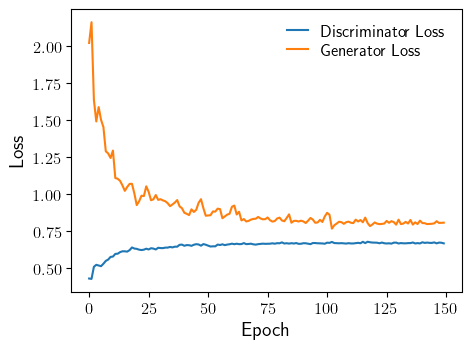

In [5]:
if os.path.isfile('losses.npy'):
    losses = np.load('losses.npy')
else:
    os.makedirs(os.path.join(os.getcwd(), 'generator_samples'), exist_ok=True)
    losses = train(epochs=150)
    np.save('losses.npy', losses)

_, ax = plt.subplots()
ax.plot(losses[:, 0], label='Discriminator Loss')
ax.plot(losses[:, 1], label='Generator Loss')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()